In [17]:
import re
import random
import pandas as pd
import hashlib

In [18]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [19]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
OAuth 2.0 RFC6749,86.051851,7.822896,9.913343,11
pfSense,123.119742,10.259978,17.093644,12
Accounting,131.867089,7.756888,13.290653,17
Pandas,157.874971,52.624990,61.601387,3
"The Starless Crown, Rollins",160.161391,5.931903,12.351902,27
Python + Oauth2.0,437.459702,19.019987,28.976867,23
Azure Files Documentation,569.819672,17.806865,35.932851,32
Azure DevOps Pipelines,652.640120,108.773353,180.704669,6
Terraform,1020.562385,102.056239,223.344199,10
Azure Developer Associate,1213.450352,101.120863,339.397795,12


# Histogram

sum of ages: ~51085.78


<Axes: >

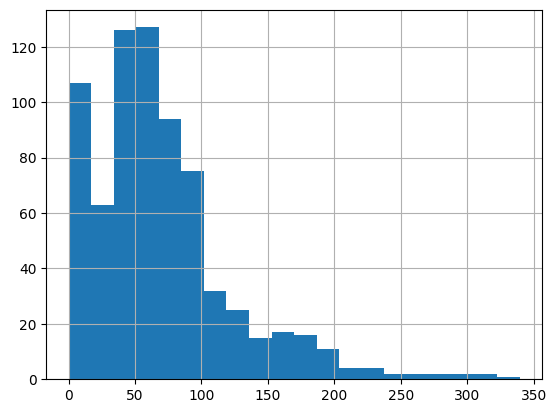

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~51085.78


<Axes: >

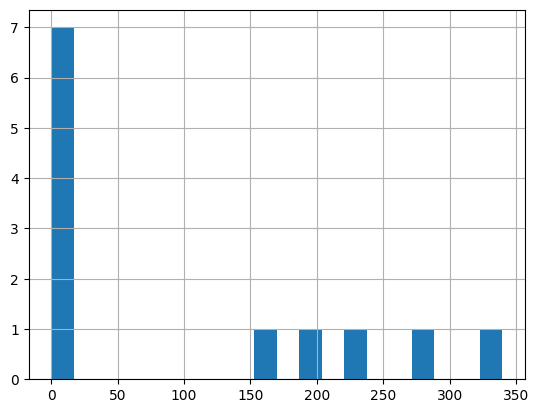

In [21]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [24]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [25]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [26]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 727
Total card age: 51085.78


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
18,Azure Developer Associate,As the .NET SDK for Azure Cosmos DB for NoSQL ...,e7d9d1bada8400673bd3bdf99e9f3c40,339.397795,101.120863,-339.397795,1213.450352,0.055342,12,0,0,-339.397795
19,Azure Developer Associate,"In the Azure Service Bus Peek Lock mode, the r...",7cab65cc344de0256430a9d4d2ce94af,197.226140,101.120863,-339.397795,1213.450352,0.055342,12,3,0,-197.226140
725,Azure Developer Associate,Event Hubs Capture Destinations\n\nEvent Hubs ...,d97ff16babcaaf97b519412da69f98f3,2.211922,101.120863,-339.397795,1213.450352,0.055342,12,6,0,-2.211922
724,Azure Developer Associate,API Management – Policies\n\nPolicies are prog...,3a601841b6ed305b549a0b6bbfed7a44,1.538573,101.120863,-339.397795,1213.450352,0.055342,12,9,0,-1.538573
0,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,318.713331,96.361777,-318.713331,5107.174179,0.447440,53,0,0,-318.713331
1,Python,Q:\nHow can you display help messages for comm...,bce20d24a97546798e080c25c5a8e43b,176.936219,96.361777,-318.713331,5107.174179,0.447440,53,3,0,-176.936219
2,Python,Q:\nHow do you add a required positional argum...,c0201a38417ca76ea898079c48323d39,154.417631,96.361777,-318.713331,5107.174179,0.447440,53,6,0,-154.417631
3,Python,Q:\nHow can you nest multiple tqdm progress ba...,9239afbc6a793b11a53d279b51771fd8,127.469153,96.361777,-318.713331,5107.174179,0.447440,53,9,0,-127.469153
4,Python,Q:\nName a common use case for generators in P...,2aba734c090b45cee3552b76252224d3,113.272757,96.361777,-318.713331,5107.174179,0.447440,53,12,0,-113.272757
5,Python,Q:\nWhat function from the os module is used t...,3372af51876bb27b0c1de083ad1ac194,99.004562,96.361777,-318.713331,5107.174179,0.447440,53,15,0,-99.004562


## Card Count

In [27]:
# n=4
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [28]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [29]:
existing_cards.head(10)['age'].sum()

np.float64(1530.1880821349737)

In [30]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
18,Azure Developer Associate,As the .NET SDK for Azure Cosmos DB for NoSQL ...,e7d9d1bada8400673bd3bdf99e9f3c40,339.397795,101.120863,-339.397795,1213.450352,0.055342,12,0,0,-339.397795
0,Python,Q:\nWhat is the primary purpose of exit codes ...,d5ae26a1eb6bf1e733080a8396f21e2d,318.713331,96.361777,-318.713331,5107.174179,0.447440,53,0,0,-318.713331
20,FSLogix,A full VHD(x) clone is performed when Cloud Ca...,71af619ba0f37ffd62aa637176cd6ef4,312.910261,99.584802,-312.910261,1792.526440,0.537725,18,0,0,-312.910261
26,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,291.802459,99.120419,-291.802459,2775.371732,0.284347,28,0,0,-291.802459
248,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,291.649069,96.361777,-318.713331,5107.174179,0.447440,53,1,1,-291.649069
36,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,287.547001,91.265386,-287.547001,4472.003907,0.878405,49,0,0,-287.547001
266,Azure Developer Associate,"Q: In Azure Storage, which feature allows revo...",b18514066eebd7faf9c8ac3843d058c0,278.198214,101.120863,-339.397795,1213.450352,0.055342,12,1,1,-278.198214
53,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,257.182152,94.687495,-257.182152,3598.124792,0.175322,38,0,0,-257.182152
299,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,254.605047,94.687495,-257.182152,3598.124792,0.175322,38,1,1,-254.605047
66,VMWare,Type 1 Hypervisor\n\nA hypervisor that runs di...,69a3327d36d550a31995e37ddee2031e,253.874285,103.227073,-253.874285,3819.401715,0.889952,37,0,0,-253.874285


In [31]:
existing_cards['age'].mean()

np.float64(70.26929261300813)